In [ ]:
# Speaker recognition of a team
# Team members: Navid, Zohreh, Nabil

**Our process:**

*   We prepare a dataset of speech samples from different speakers, with the speaker as label.

*   We add background noise to these samples to augment our data.
We take the FFT of these samples.

*   We train a 1D convnet to predict the correct speaker given a noisy FFT speech sample.

In [ ]:
# install Kaggle library to import our dataset from https://kaggle.com/
!pip install Kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import needed libraries
from google.colab import files
import os 
from os.path import isfile, join
import numpy as np
import tensorflow as tf
from tensorflow import keras
import shutil
from pathlib import Path
from IPython.display import display, Audio
import subprocess

In [ ]:
# remove (if exists) the folder: kaggle
!rm -r ~/.kaggle
# make the folder: kaggle
!mkdir ~/.kaggle

rm: cannot remove '/root/.kaggle': No such file or directory


**Upload your kaggle.json file**

In [ ]:
# upload a kaggle.json to Load Kaggle datasets directly into Google Colab
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rsm2213839","key":"b565aa28dbf86443f13721a7537ff5e8"}'}

In [ ]:
# move kaggle.json file in kaggle folder
!mv ./kaggle.json ~/.kaggle/
# giving read and write access
!chmod 600 ~/.kaggle/kaggle.json

**Download your recorded voice for model trianing.**


In [ ]:
# download our dataset from https://www.kaggle.com/datasets/rsm2213839/3speakerswithnoise2
!kaggle datasets download rsm2213839/3speakerswithnoise2

100% 191M/191M [00:09<00:00, 23.3MB/s]
100% 191M/191M [00:09<00:00, 21.7MB/s]


In [ ]:
# unzip the downloaded dataset: speaker-recognition.zip
! unzip 3speakerswithnoise2.zip

Archive:  3speakerswithnoise2.zip
  inflating: speaker-recognition/Nabil/chunk0.wav  
  inflating: speaker-recognition/Nabil/chunk1.wav  
  inflating: speaker-recognition/Nabil/chunk10.wav  
  inflating: speaker-recognition/Nabil/chunk100.wav  
  inflating: speaker-recognition/Nabil/chunk1000.wav  
  inflating: speaker-recognition/Nabil/chunk1001.wav  
  inflating: speaker-recognition/Nabil/chunk1002.wav  
  inflating: speaker-recognition/Nabil/chunk1003.wav  
  inflating: speaker-recognition/Nabil/chunk1004.wav  
  inflating: speaker-recognition/Nabil/chunk1005.wav  
  inflating: speaker-recognition/Nabil/chunk1006.wav  
  inflating: speaker-recognition/Nabil/chunk1007.wav  
  inflating: speaker-recognition/Nabil/chunk1008.wav  
  inflating: speaker-recognition/Nabil/chunk1009.wav  
  inflating: speaker-recognition/Nabil/chunk101.wav  
  inflating: speaker-recognition/Nabil/chunk1010.wav  
  inflating: speaker-recognition/Nabil/chunk1011.wav  
  inflating: speaker-recognition/Nabil/ch

In [ ]:
data_directory = "./speaker-recognition"
audio_folder = "audio"
noise_folder = "noise"
# Join two pathname components
audio_path = os.path.join(data_directory, audio_folder)
noise_path = os.path.join(data_directory, noise_folder)

In [ ]:
# set all the parameters for training and other purposes
valid_split = 0.1
shuffle_seed = 43
sample_rate = 16000
scale = 0.5
batch_size = 200 # Batch size does not affect your accuracy. This is just used to control the speed or performance based on the memory in your GPU. If you have huge memory, you can have a huge batch size so training will be faster.
epochs = 40 # Epoch sizes can increase the accuracy up to a certain limit beyond which you begin to overfit your model. Having a very low one will also result in underfitting.

In [ ]:
# Copy dataset to audio and noise folder
for folder in os.listdir(data_directory):
    if os.path.isdir(os.path.join(data_directory, folder)):
        if folder in [audio_folder, noise_folder]:
            continue
        # Copy noise dataset to noise folder
        elif folder in ["other", "_background_noise_"]:
            shutil.move(os.path.join(data_directory, folder),os.path.join(noise_path, folder))
        # Copy speakers' dataset to audio folder
        else:
            shutil.move(os.path.join(data_directory, folder),os.path.join(audio_path, folder))

In [ ]:
# Get the list of all noise files
noise_paths = []
for subdir in os.listdir(noise_path):
    subdir_path = Path(noise_path) / subdir
    if os.path.isdir(subdir_path):
        noise_paths += [os.path.join(subdir_path, filepath) for filepath in os.listdir(subdir_path) if filepath.endswith(".wav")]

In [ ]:
# Split noise into chunks of 16,000 steps each
# Command to execute
command = ("for dir in `ls -1 " + noise_path + "`; do ""for file in `ls -1 " + noise_path + "/$dir/*.wav`; do "
    "sample_rate=`ffprobe -hide_banner -loglevel panic -show_streams " "$file | grep sample_rate | cut -f2 -d=`; "
    "if [ $sample_rate -ne 16000 ]; then " "ffmpeg -hide_banner -loglevel panic -y "
    "-i $file -ar 16000 temp.wav; " "mv temp.wav $file; " "fi; done; done")
# Using os.system() method to execute command
os.system(command)
def load_noise_sample(path):
    # tf.audio.decode_wav: Decode a wav file from its contents.
    #                      Args: input_bytes: a byte array or Tensor with the wav file contents.
    #                      Returns: A pair of Tensor for sample rate, decoded samples.
    sample, sampling_rate = tf.audio.decode_wav(tf.io.read_file(path), desired_channels=1)
    if sampling_rate == sample_rate:
        slices = int(sample.shape[0] / sample_rate)
        # tf.split: Splits a tensor value into a list of sub tensors.
        sample = tf.split(sample[: slices * sample_rate], slices)
        return sample
    else:
        print("Sampling rate for",path, "is incorrect")
        return None
noises = []
for path in noise_paths:
    sample = load_noise_sample(path) # use our load_noise_sample function
    if sample:
        noises.extend(sample) # adds the specified list elements (sample) to the end of the current list (noises)
noises = tf.stack(noises) # Stacks a list of tensors

**DATASET GENERATION**

In [ ]:
# Creat dataset from paths and labels
def paths_and_labels_to_dataset(audio_paths, labels):
    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths) # creates a dataset with a separate element for each row of the input tensor
    audio_ds = path_ds.map(lambda x: path_to_audio(x)) # Maps map_func across the elements of this dataset 
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    return tf.data.Dataset.zip((audio_ds, label_ds))

In [ ]:
def path_to_audio(path):
    audio = tf.io.read_file(path) # This operation returns a tensor with the entire contents of the input filename
    audio, _ = tf.audio.decode_wav(audio, 1, sample_rate) # Decode a 16-bit PCM WAV file to a float tensor (returns a tuple of Tensor objects (audio, sample_rate))
    return audio

In [ ]:
# add noise to dataset
def add_noise(audio, noises=None, scale=scale):
    if noises is not None:
        tf_rnd = tf.random.uniform((tf.shape(audio)[0],), 0, noises.shape[0], dtype=tf.int32) # Outputs random values from a uniform distribution
        noise = tf.gather(noises, tf_rnd, axis=0) # Gather slices from params axis according to indices
        prop = tf.math.reduce_max(audio, axis=1) / tf.math.reduce_max(noise, axis=1) # maximum of elements across dimensions of audio/maximum of elements across dimensions of noise
        prop = tf.repeat(tf.expand_dims(prop, axis=1), tf.shape(audio)[1], axis=1) # Repeat elements of input
        audio = audio + noise * prop * scale
    return audio

# compute fft of the audio
def audio_to_fft(audio):
    audio = tf.squeeze(audio, axis=-1) # Removes dimensions of size 1 from the shape of a tensor
    fft = tf.signal.fft(tf.cast(tf.complex(real=audio, imag=tf.zeros_like(audio)), tf.complex64)    ) # compute the Fast Fourier transform
    fft = tf.expand_dims(fft, axis=-1)  # used to insert an addition dimension in input Tensor (axis=-1 adds an inner most dimension)
    return tf.math.abs(fft[:, : (audio.shape[1] // 2), :]) # Computes the absolute value of a tensor

In [ ]:
# get lables and audio paths
class_names = os.listdir(audio_path)
print(class_names,)

audio_paths = []
labels = []
for label, name in enumerate(class_names):
    print("Speaker:",(name))
    dir_path = Path(audio_path) / name
    speaker_sample_paths = [os.path.join(dir_path, filepath) for filepath in os.listdir(dir_path) if filepath.endswith(".wav")]
    audio_paths += speaker_sample_paths
    labels += [label] * len(speaker_sample_paths)

['Zohreh', 'Nabil', 'Navid']
Speaker: Zohreh
Speaker: Nabil
Speaker: Navid


In [ ]:
# Shuffle to generate random data
rng = np.random.RandomState(shuffle_seed) # RandomState exposes a number of methods for generating random numbers drawn from a variety of probability distributions. Argument: seed used to initialize the pseudo-random number generator
rng.shuffle(audio_paths) # shuffles the array along the first axis of a multi-dimensional array
rng = np.random.RandomState(shuffle_seed) # exposes a number of methods for generating random numbers drawn from a variety of probability distributions
rng.shuffle(labels) # shuffling its contents

In [ ]:
# Split into training and validation
num_val_samples = int(valid_split * len(audio_paths))
train_audio_paths = audio_paths[:-num_val_samples]
train_labels = labels[:-num_val_samples]

valid_audio_paths = audio_paths[-num_val_samples:]
valid_labels = labels[-num_val_samples:]

In [ ]:
# Create datasets, one for training and the other for validation
train_ds = paths_and_labels_to_dataset(train_audio_paths, train_labels)
train_ds = train_ds.shuffle(buffer_size=batch_size * 8, seed=shuffle_seed).batch(batch_size)

valid_ds = paths_and_labels_to_dataset(valid_audio_paths, valid_labels)
valid_ds = valid_ds.shuffle(buffer_size=32 * 8, seed=shuffle_seed).batch(32)

In [ ]:
type(valid_ds)

tensorflow.python.data.ops.batch_op._BatchDataset

**feature Extraction**

In [ ]:
# Add noise to the training set
train_ds = train_ds.map(lambda x, y: (add_noise(x, noises, scale=scale), y),num_parallel_calls=tf.data.experimental.AUTOTUNE)
# Transform audio wave to the frequency domain using `audio_to_fft`
train_ds = train_ds.map(lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)

valid_ds = valid_ds.map(lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
valid_ds = valid_ds.prefetch(tf.data.experimental.AUTOTUNE)

**Model**

Keras layers API
Layers are the basic building blocks of neural networks in Keras. A layer consists of a tensor-in tensor-out computation function (the layer's call method) and some state, held in TensorFlow variables (the layer's weights).

A Layer instance is callable, much like a function. Unlike a function, though, layers maintain a state, updated when the layer receives data during training, and stored in layer.weights. 

Creating custom layers
While Keras offers a wide range of built-in layers, they don't cover ever possible use case. Creating custom layers is very common, and very easy.


In [ ]:
from tensorflow.keras.layers import Conv1D

In [ ]:
# keras model
def residual_block(x, filters, conv_num=3, activation="relu"):
    # Shortcut
    s = keras.layers.Conv1D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
        x = keras.layers.Conv1D(filters, 3, padding="same")(x)
        x = keras.layers.Activation(activation)(x)
    x = keras.layers.Conv1D(filters, 3, padding="same")(x)
    x = keras.layers.Add()([x, s])
    x = keras.layers.Activation(activation)(x)
    return keras.layers.MaxPool1D(pool_size=2, strides=2)(x)


def build_model(input_shape, num_classes):
    inputs = keras.layers.Input(shape=input_shape, name="input")

    x = residual_block(inputs, 16, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 128, 3)
    x = residual_block(x, 128, 3)

    x = keras.layers.AveragePooling1D(pool_size=3, strides=3)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dense(128, activation="relu")(x)

    outputs = keras.layers.Dense(num_classes, activation="softmax", name="output")(x)

    return keras.models.Model(inputs=inputs, outputs=outputs)


model = build_model((sample_rate // 2, 1), len(class_names))

model.summary()

# Compile the model using Adam's default learning rate
model.compile(
    optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# Add callbacks:
# 'EarlyStopping' to stop training when the model is not enhancing anymore
# 'ModelCheckPoint' to always keep the model that has the best val_accuracy
model_save_filename = "model.h5"

earlystopping_cb = keras.callbacks.EarlyStopping(patience=35, restore_best_weights=True)
mdlcheckpoint_cb = keras.callbacks.ModelCheckpoint(
    model_save_filename, monitor="val_accuracy", save_best_only=True
)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 8000, 1)]    0           []                               
                                                                                                  
 conv1d_19 (Conv1D)             (None, 8000, 16)     64          ['input[0][0]']                  
                                                                                                  
 activation_13 (Activation)     (None, 8000, 16)     0           ['conv1d_19[0][0]']              
                                                                                                  
 conv1d_20 (Conv1D)             (None, 8000, 16)     784         ['activation_13[0][0]']          
                                                                                            

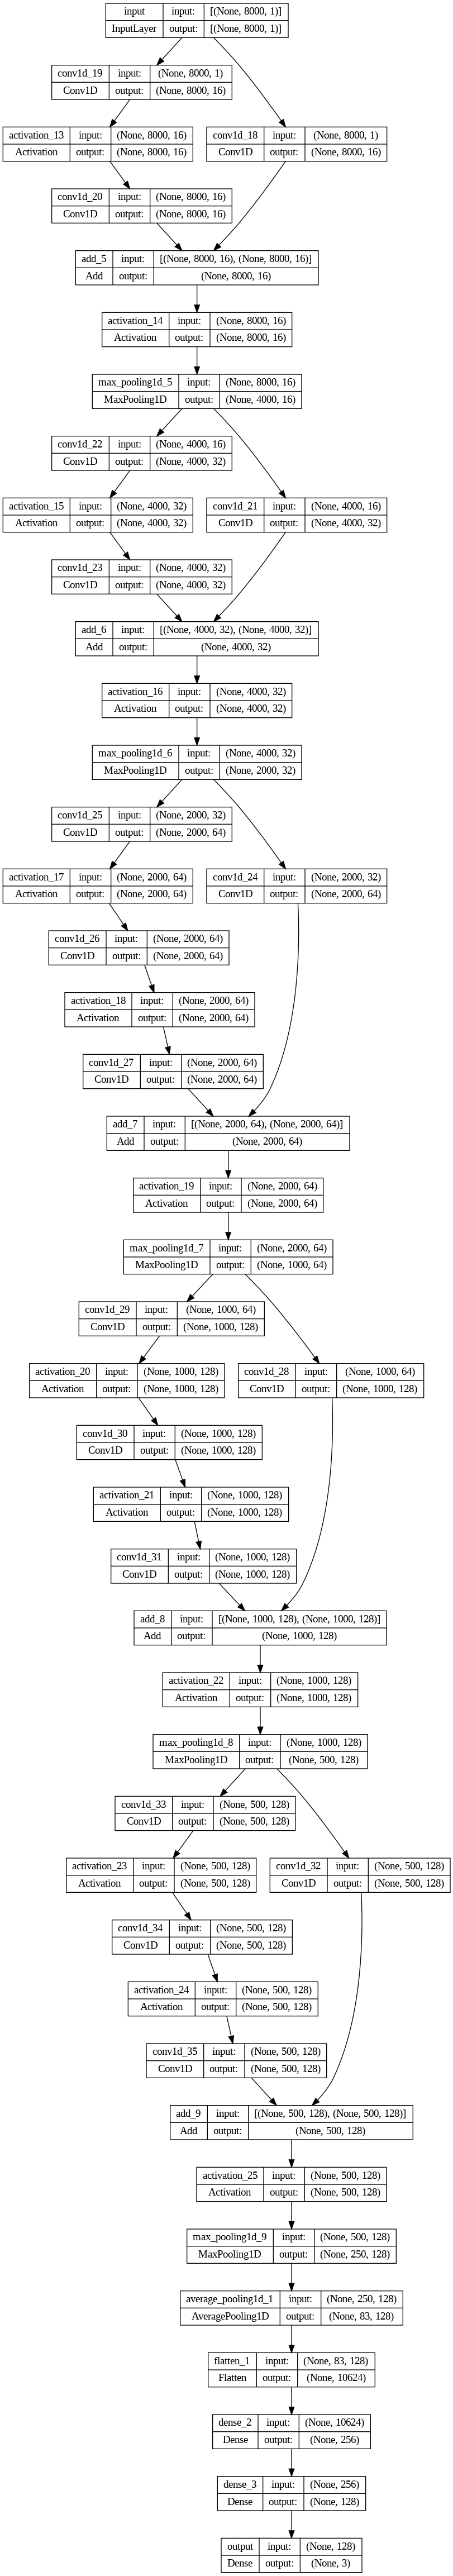

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# our model
def residual_block(x, filters, conv_num = 3, activation = "relu"):
    """
     1D convolution layer: 
     This layer creates a convolution kernel that is convolved with the layer 
     input over a single spatial (or temporal) dimension to produce a tensor of outputs.
     Arguments: 
     filters: Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution).
     Kernel size: specifying the length of the 1D convolution window
     padding: "same" results in padding with zeros evenly to the left/right or up/down of the input such that output has the same height/width dimension as the input. 
    """
    s = keras.layers.Conv1D(filters, 1, padding = "same")(x)
    
    for i in range(conv_num - 1):
        x = keras.layers.Conv1D(filters, 3, padding = "same")(x)
        x = keras.layers.Activation(activation)(x) # Applies an activation function to an output.
    
    x = keras.layers.Conv1D(filters, 3, padding = "same")(x)
    x = keras.layers.Add()([x, s]) # Layer that adds a list of inputs.It takes as input a list of tensors, all of the same shape, and returns a single tensor (also of the same shape).
    x = keras.layers.Activation(activation)(x)
    
    return keras.layers.MaxPool1D(pool_size = 2, strides = 2)(x) # Max pooling operation for 1D temporal data.

def build_model(input_shape, num_classes):
    inputs = keras.layers.Input(shape = input_shape, name = "input") # used to instantiate a Keras tensor (shape: A shape tuple, name: An optional name string for the layer)
    
    x = residual_block(inputs, 16, 2) # our residual_block function: (x, filters, conv_num, activation = "relu")
    x = residual_block(inputs, 32, 2)
    x = residual_block(inputs, 64, 3)
    x = residual_block(inputs, 128, 3)
    x = residual_block(inputs, 128, 3)
    x = keras.layers.AveragePooling1D(pool_size=3, strides=3)(x) # Average pooling for temporal data.
    x = keras.layers.Flatten()(x) # Flattens the input.
    x = keras.layers.Dense(256, activation="relu")(x) # Dense Layer is used to classify image based on output from convolutional layers. 
    x = keras.layers.Dense(128, activation="relu")(x)
    
    outputs = keras.layers.Dense(num_classes, activation = "softmax", name = "output")(x)
    
    return keras.models.Model(inputs = inputs, outputs = outputs)

# We have used the same model as recommended for peaker recognition in https://keras.io/examples/audio/speaker_recognition_using_cnn
# Becuase it worked well with our dataset aswell
model = build_model((sample_rate // 2, 1), len(class_names)) # run our build model function

model.summary() # see model summery

model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]) # Configures the model for training.

model_save_filename = "model.h5"

earlystopping_cb = keras.callbacks.EarlyStopping(patience=35, restore_best_weights=True) # Stop training when a monitored metric has stopped improving.

mdlcheckpoint_cb = keras.callbacks.ModelCheckpoint(model_save_filename, monitor="val_accuracy", save_best_only=True) # Callback to save the Keras model or model weights at some frequency.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 8000, 1)]    0           []                               
                                                                                                  
 conv1d_15 (Conv1D)             (None, 8000, 128)    512         ['input[0][0]']                  
                                                                                                  
 activation_10 (Activation)     (None, 8000, 128)    0           ['conv1d_15[0][0]']              
                                                                                                  
 conv1d_16 (Conv1D)             (None, 8000, 128)    49280       ['activation_10[0][0]']          
                                                                                              

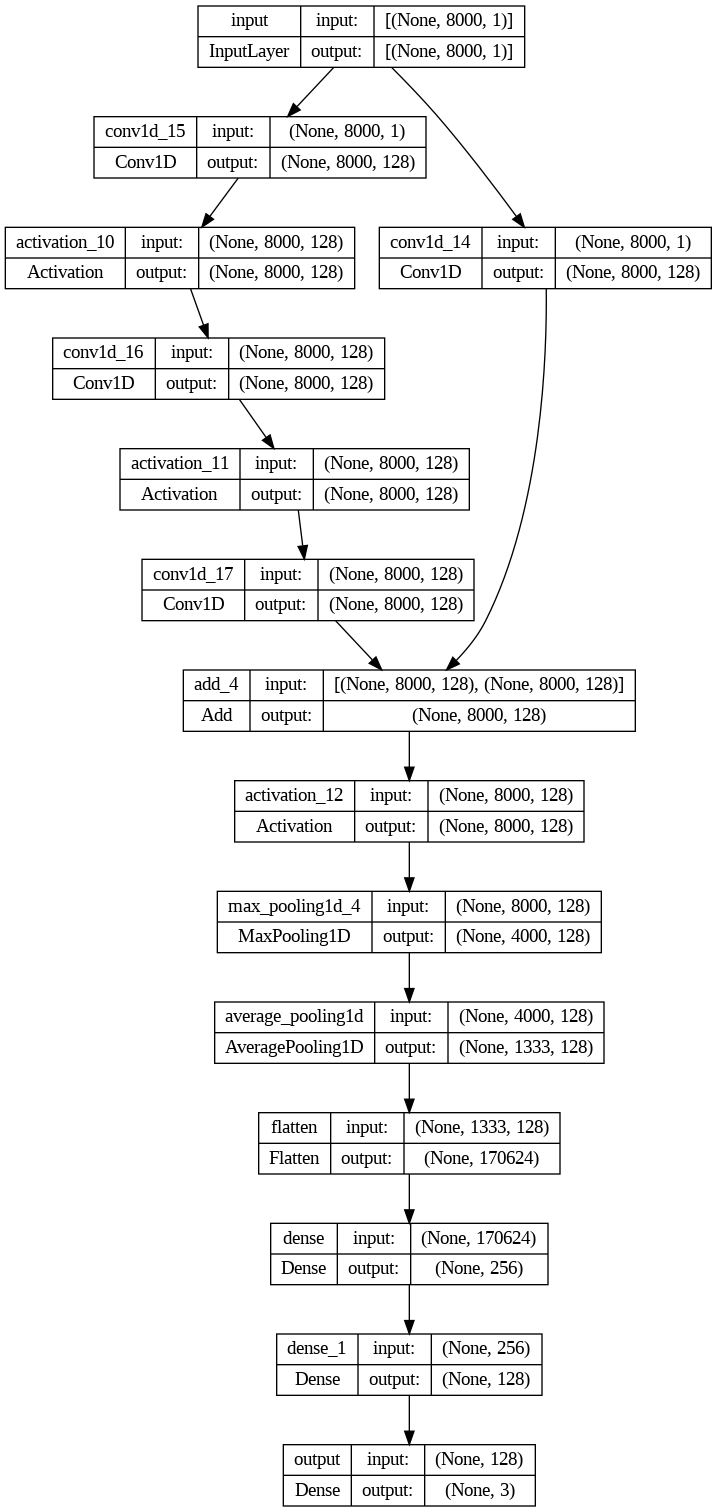

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

**Training**

In [ ]:
history = model.fit(train_ds,epochs=epochs,validation_data=valid_ds,callbacks=[earlystopping_cb, mdlcheckpoint_cb])

Epoch 1/50
22/22 [==============================] - 43s 984ms/step - loss: 7.1779 - accuracy: 0.4743 - val_loss: 1.0767 - val_accuracy: 0.5125
Epoch 2/50
22/22 [==============================] - 22s 925ms/step - loss: 0.5400 - accuracy: 0.8277 - val_loss: 0.5577 - val_accuracy: 0.7875
Epoch 3/50
22/22 [==============================] - 22s 930ms/step - loss: 0.1991 - accuracy: 0.9193 - val_loss: 0.3448 - val_accuracy: 0.8646
Epoch 4/50
22/22 [==============================] - 24s 1s/step - loss: 0.1254 - accuracy: 0.9537 - val_loss: 0.2918 - val_accuracy: 0.9021
Epoch 5/50
22/22 [==============================] - 23s 993ms/step - loss: 0.1158 - accuracy: 0.9588 - val_loss: 0.2225 - val_accuracy: 0.9375
Epoch 6/50
22/22 [==============================] - 21s 900ms/step - loss: 0.1346 - accuracy: 0.9491 - val_loss: 0.3968 - val_accuracy: 0.8792
Epoch 7/50
22/22 [==============================] - 20s 851ms/step - loss: 0.0933 - accuracy: 0.9685 - val_loss: 0.3165 - val_accuracy: 0.9229
Ep

**Accuracy**

In [ ]:
print("Loss and Accuracy of model:",model.evaluate(valid_ds)) # evaluate model performance. Higher accuracy and lower loss is better

15/15 [==============================] - 2s 95ms/step - loss: 0.3888 - accuracy: 0.9458
Loss and Accuracy of model: [0.3888128995895386, 0.9458333253860474]


**Predict the speaker from the test dataset for real time prediction.**

In [ ]:
#def paths_to_dataset(audio_paths):
#    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
#    return tf.data.Dataset.zip((path_ds))

def predict(path, labels):
    test = paths_and_labels_to_dataset(path, labels) # use our paths_and_labels_to_dataset function
    test = test.batch(batch_size) # batch dataset
    test = test.prefetch(tf.data.experimental.AUTOTUNE) # Creates a Dataset that prefetches elements from this dataset
    #test = test.map(lambda x, y: (add_noise(x, noises, scale=scale), y))
    for audios, labels in test.take(1):
        ffts = audio_to_fft(audios) # use our audio_to_fft function
        y_pred = model.predict(ffts) # prediction
        print("Similarity to Nabil, Zohreh and Navid respectively:",y_pred[0])
        index = np.argmax(y_pred[0]) # we choose the class with highest probability as our prediction result
        if y_pred[0][index]>0.9:
          print("So \nSpeaker Predicted:",class_names[index])
        else:
          print("New person. (We are not 90% sure!)")


**Now provide your test file for real time prediction:**

In [ ]:
!kaggle datasets download rsm2213839/hello1 # download from kaggle
#files.upload() # or upload from pc

  0% 0.00/37.5k [00:00<?, ?B/s]
100% 37.5k/37.5k [00:00<00:00, 17.9MB/s]


In [ ]:
! unzip hello1.zip # unzip file

Archive:  hello1.zip
  inflating: Hello-Zohreh.wav        


In [ ]:
cwd = os.getcwd()
cwd

'/content'

In [ ]:
path = ["/content/Hello-Zohreh.wav"]
labels = ["unknown"]
predict(path, labels) # make prediction

1/1 [==============================] - 0s 339ms/step
Similarity to Nabil, Zohreh and Navid respectively: [0.0000000e+00 1.0000000e+00 1.2932504e-18]
So 
Speaker Predicted: Zohreh


**Predicted one new data from Zohreh successfully!**

uncomment the two following cells if you want to upload a new 1 second file for prediction.

In [ ]:
#files.upload()

In [ ]:
#path = ["../content/chunk7.wav"]
#labels = ["unknown"]
#predict(path, labels) # make prediction

**Note:**

Now we try another recording which is about 8 seconds and we will consider our predictions for all its seconds and then make our final desicion based on all the seconds. If our prediction for more than **90 percent of the seconds** is an identical person, we will announce this person as our Final decision. Otherwise we will conclude that this voice is from a **new person**.

**Upload your zip file:**


In [ ]:
!kaggle datasets download rsm2213839/new-person-test

  0% 0.00/327k [00:00<?, ?B/s]
100% 327k/327k [00:00<00:00, 116MB/s]


In [ ]:
#files.upload()

In [ ]:
! unzip new-person-test.zip

Archive:  new-person-test.zip
  inflating: content/new/splited/chunk0.wav  
  inflating: content/new/splited/chunk1.wav  
  inflating: content/new/splited/chunk2.wav  
  inflating: content/new/splited/chunk3.wav  
  inflating: content/new/splited/chunk4.wav  
  inflating: content/new/splited/chunk5.wav  
  inflating: content/new/splited/chunk6.wav  
  inflating: content/new/splited/chunk7.wav  


In [ ]:
! pip install glob2
import glob2
name = glob2.glob('content/new/splited/*.wav')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Change path in the next cell to the uploaded file name**


In [ ]:
#SAMPLES_TO_DISPLAY = 1
os.chdir("content/new/splited") # change directory
labels = [""]
seconds = len(name)
conclusion = np.zeros(seconds) + 3

for sec in range(seconds):
  path = name[sec]
  mylen = len('content/new/splited/')
  path = path[mylen:]
  path = [path]
  test = paths_and_labels_to_dataset(path, labels) # use our paths_and_labels_to_dataset function
  test = test.batch(batch_size) # batch dataset
  test = test.prefetch(tf.data.experimental.AUTOTUNE) # Creates a Dataset that prefetches elements from this dataset
  for audios, labels in test.take(1):
      ffts = audio_to_fft(audios) # use our audio_to_fft function
      y_pred = model.predict(ffts) # prediction
      print("Similarity to Nabil, Zohreh and Navid respectively:",y_pred[0])
      index = np.argmax(y_pred[0]) # we choose the class with highest probability as our prediction result
      if y_pred[0][index]>0.95:
        conclusion[sec] = index

print("Conclusion for each second: " )
for sec in range(seconds):
  if conclusion[sec]<3:
    print(sec, "- ", class_names[int(conclusion[sec])])
  else:
    print(sec, "- ", 'New person')
num0 = 0
num1 = 0
num2 = 0
num3 = 0
for i in range(seconds):
  if conclusion[i]==0:
    num0 = num0 +1
  if conclusion[i]==1:
    num1 = num1 +1
  if conclusion[i]==2:
    num2 = num2 +1
  if conclusion[i]==3:
    num3 = num3 +1
numall = [num0, num1, num2, num3]
IndF = np.argmax(numall)
if max(numall) > (0.9*seconds) :
  print("Final decision: ", class_names[IndF])
else:
  print("Final decision: New person")
os.chdir('/content') # change directory

1/1 [==============================] - 0s 27ms/step
Similarity to Nabil, Zohreh and Navid respectively: [5.5122161e-01 4.4861841e-01 1.5999531e-04]
1/1 [==============================] - 0s 17ms/step
Similarity to Nabil, Zohreh and Navid respectively: [6.1295298e-03 9.9385840e-01 1.2107959e-05]
1/1 [==============================] - 0s 21ms/step
Similarity to Nabil, Zohreh and Navid respectively: [1.540029e-01 8.453414e-01 6.556979e-04]
1/1 [==============================] - 0s 22ms/step
Similarity to Nabil, Zohreh and Navid respectively: [8.8032056e-07 9.9999917e-01 7.0147161e-12]
1/1 [==============================] - 0s 19ms/step
Similarity to Nabil, Zohreh and Navid respectively: [9.9999750e-01 1.6077421e-06 9.3107030e-07]
1/1 [==============================] - 0s 18ms/step
Similarity to Nabil, Zohreh and Navid respectively: [2.0982621e-02 9.7901720e-01 2.0584878e-07]
1/1 [==============================] - 0s 20ms/step
Similarity to Nabil, Zohreh and Navid respectively: [1.000000e+

**Note:**

Since the accuracy of our model is about 96%, if the uploaded voice belongs to a team member, it should predict the speaker's name correctly almost every second.

So when we see that this is not the case almost every second, it is reasonable to consider the voice as belonging to a new person.

In [ ]:
os.chdir('/content') # change directory

**Predict sample in validation data**

In [ ]:
SAMPLES_TO_DISPLAY = 10

test_ds = paths_and_labels_to_dataset(valid_audio_paths, valid_labels) # use our paths_and_labels_to_dataset function
test_ds = test_ds.shuffle(buffer_size=batch_size * 8, seed=shuffle_seed).batch(batch_size) # shuffle and batch dataset

for audios, labels in test_ds.take(1):
    ffts = audio_to_fft(audios) # use our audio_to_fft function
    y_pred = model.predict(ffts) # make predictions   
    rnd = np.random.randint(0, batch_size, SAMPLES_TO_DISPLAY) # Returns random integers from low to high
    audios0 = audios.numpy()[rnd, :, :] # converts a tensor object into an numpy.ndarray object
    labels0 = labels.numpy()[rnd] # converts a tensor object into an numpy.ndarray object
    y_pred = y_pred[rnd]
    y_pred_ind = np.argmax(y_pred, axis=-1) # we choose the class with highest probability as our prediction result
    print("y_pred_ind: ",y_pred_ind)
    numm = 0
    for i in range(SAMPLES_TO_DISPLAY):
        print("Speaker:\33{} {}\33[0m\tPredicted:\33{} {}\33[0m".format(
                "[92m" if labels0[i] == y_pred_ind[i] else "[91m",class_names[labels0[i]],
                "[92m" if labels0[i] == y_pred_ind[i] else "[91m",class_names[y_pred_ind[i]]))
        if labels0[i] ==y_pred_ind[i]:
            print("Yay! Correct recognition. Similarity to Nabil, Zohreh and Navid respectivevly: ", y_pred[i])
        else:
            print("Sorry. Wrong recognition. Similarity to Nabil, Zohreh and Navid respectivevly: ", y_pred[i])


7/7 [==============================] - 0s 61ms/step
y_pred_ind:  [2 0 0 0 0 2 1 1 1 0]
Speaker: Navid	Predicted: Navid
Yay! Correct recognition. Similarity to Nabil, Zohreh and Navid respectivevly:  [3.6575477e-07 3.2347188e-08 9.9999964e-01]
Speaker: Nabil	Predicted: Nabil
Yay! Correct recognition. Similarity to Nabil, Zohreh and Navid respectivevly:  [1. 0. 0.]
Speaker: Nabil	Predicted: Nabil
Yay! Correct recognition. Similarity to Nabil, Zohreh and Navid respectivevly:  [1.0000000e+00 1.2185272e-38 9.4483361e-29]
Speaker: Nabil	Predicted: Nabil
Yay! Correct recognition. Similarity to Nabil, Zohreh and Navid respectivevly:  [1. 0. 0.]
Speaker: Nabil	Predicted: Nabil
Yay! Correct recognition. Similarity to Nabil, Zohreh and Navid respectivevly:  [1.000000e+00 4.920171e-27 2.076433e-23]
Speaker: Navid	Predicted: Navid
Yay! Correct recognition. Similarity to Nabil, Zohreh and Navid respectivevly:  [4.0823680e-15 2.6944954e-15 1.0000000e+00]
Speaker: Zohreh	Predicted: Zohreh
Yay! Correct

**Note:** 

If you want to test with another file upload the output file from  SplitToOneSec-v3.ipynb. 

Then change the file name .

In [ ]:
shutil.rmtree('content/new/splited')

In [ ]:
files.upload()
! unzip OneSecFiles.zip

Saving OneSecFiles.zip to OneSecFiles.zip
Archive:  OneSecFiles.zip
replace content/new/splited/chunk2.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: content/new/splited/chunk2.wav  
replace content/new/splited/chunk0.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: 
error:  invalid response [{ENTER}]
replace content/new/splited/chunk0.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: content/new/splited/chunk0.wav  
  inflating: content/new/splited/chunk9.wav  
  inflating: content/new/splited/chunk7.wav  
  inflating: content/new/splited/chunk4.wav  
  inflating: content/new/splited/chunk3.wav  
  inflating: content/new/splited/chunk10.wav  
  inflating: content/new/splited/chunk8.wav  
  inflating: content/new/splited/chunk6.wav  
  inflating: content/new/splited/chunk5.wav  
  inflating: content/new/splited/chunk1.wav  
  inflating: content/new/splited/chunk11.wav  
  inflating: content/new/splited/chunk13.wav  
  inflating: content/new/splited/chunk12.wav  


In [ ]:
name = glob2.glob('content/new/splited/*.wav')
#os.chdir("content") # change directory
os.chdir("content/new/splited") # change directory
labels = [""]
seconds = len(name)
conclusion = np.zeros(seconds) + 3

for sec in range(seconds):
  path = name[sec]
  mylen = len('content/new/splited/')
  path = path[mylen:]
  path = [path]
  test = paths_and_labels_to_dataset(path, labels) # use our paths_and_labels_to_dataset function
  test = test.batch(batch_size) # batch dataset
  test = test.prefetch(tf.data.experimental.AUTOTUNE) # Creates a Dataset that prefetches elements from this dataset
  for audios, labels in test.take(1):
      ffts = audio_to_fft(audios) # use our audio_to_fft function
      y_pred = model.predict(ffts) # prediction
      print("Similarity to Nabil, Zohreh and Navid respectively:",y_pred[0])
      index = np.argmax(y_pred[0]) # we choose the class with highest probability as our prediction result
      if y_pred[0][index]>0.9:
        conclusion[sec] = index
        
print("Conclusion for each second: " )
for sec in range(seconds):
  if conclusion[sec]<3:
    print(sec, "- ", class_names[int(conclusion[sec])])
  else:
    print(sec, "- ", 'New person')
num0 = 0
num1 = 0
num2 = 0
num3 = 0
for i in range(seconds):
  if conclusion[i]==0:
    num0 = num0 +1
  if conclusion[i]==1:
    num1 = num1 +1
  if conclusion[i]==2:
    num2 = num2 +1
  if conclusion[i]==3:
    num3 = num3 +1
numall = [num0, num1, num2, num3]
IndF = np.argmax(numall)
if max(numall) > (0.9*seconds) :
  print("Final decision: ", class_names[IndF])
else:
  print("Final decision: New person")
os.chdir('/content') # change directory

1/1 [==============================] - 0s 20ms/step
Similarity to Nabil, Zohreh and Navid respectively: [1.0000000e+00 1.8762708e-18 2.3641205e-13]
1/1 [==============================] - 0s 18ms/step
Similarity to Nabil, Zohreh and Navid respectively: [7.9976702e-03 2.3357518e-06 9.9199998e-01]
1/1 [==============================] - 0s 19ms/step
Similarity to Nabil, Zohreh and Navid respectively: [1.6788300e-06 9.9997461e-01 2.3702645e-05]
1/1 [==============================] - 0s 20ms/step
Similarity to Nabil, Zohreh and Navid respectively: [1.000000e+00 2.795843e-22 2.589656e-18]
1/1 [==============================] - 0s 18ms/step
Similarity to Nabil, Zohreh and Navid respectively: [1.993429e-25 1.000000e+00 5.817577e-29]
1/1 [==============================] - 0s 19ms/step
Similarity to Nabil, Zohreh and Navid respectively: [1.0000000e+00 1.9524474e-28 6.3682987e-10]
1/1 [==============================] - 0s 20ms/step
Similarity to Nabil, Zohreh and Navid respectively: [1.0000000e+00

In [ ]:
#shutil.rmtree('content')
#shutil.rmtree('speaker-recognition')
#os.remove('Hello-Zohreh.wav')
#os.remove('hello1.zip')
#os.remove('model.h5')
#os.remove('new-person-test.zip')
#os.remove('testfilespeakerrec.zip')
#os.remove('3speakerswithnoise2.zip')

In [ ]:
# our model
def residual_block(x, filters, conv_num = 3, activation = "relu"):
    """
     1D convolution layer: 
     This layer creates a convolution kernel that is convolved with the layer 
     input over a single spatial (or temporal) dimension to produce a tensor of outputs.
     Arguments: 
     filters: Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution).
     Kernel size: specifying the length of the 1D convolution window
     padding: "same" results in padding with zeros evenly to the left/right or up/down of the input such that output has the same height/width dimension as the input. 
    """
    s = keras.layers.Conv1D(filters, 1, padding = "same")(x)
    
    for i in range(conv_num - 1):
        x = keras.layers.Conv1D(filters, 3, padding = "same")(x)
        x = keras.layers.Activation(activation)(x) # Applies an activation function to an output.
    
    x = keras.layers.Conv1D(filters, 3, padding = "same")(x)
    x = keras.layers.Add()([x, s]) # Layer that adds a list of inputs.It takes as input a list of tensors, all of the same shape, and returns a single tensor (also of the same shape).
    x = keras.layers.Activation(activation)(x)
    
    return keras.layers.MaxPool1D(pool_size = 2, strides = 2)(x) # Max pooling operation for 1D temporal data.

def build_model(input_shape, num_classes):
    inputs = keras.layers.Input(shape = input_shape, name = "input") # used to instantiate a Keras tensor (shape: A shape tuple, name: An optional name string for the layer)
    
    x = residual_block(inputs, 16, 2) # our residual_block function: (x, filters, conv_num, activation = "relu")
    x = residual_block(inputs, 32, 2)
    x = residual_block(inputs, 64, 3)
    x = residual_block(inputs, 128, 3)
    x = residual_block(inputs, 128, 3)
    x = keras.layers.AveragePooling1D(pool_size=3, strides=3)(x) # Average pooling for temporal data.
    x = keras.layers.Flatten()(x) # Flattens the input.
    x = keras.layers.Dense(256, activation="relu")(x) # Dense Layer is used to classify image based on output from convolutional layers. 
    x = keras.layers.Dense(128, activation="relu")(x)
    
    outputs = keras.layers.Dense(num_classes, activation = "softmax", name = "output")(x)
    
    return keras.models.Model(inputs = inputs, outputs = outputs)

# We have used the same model as recommended for peaker recognition in https://keras.io/examples/audio/speaker_recognition_using_cnn
# Becuase it worked well with our dataset aswell
model = build_model((sample_rate // 2, 1), len(class_names)) # run our build model function

model.summary() # see model summery

model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]) # Configures the model for training.

model_save_filename = "model.h5"

earlystopping_cb = keras.callbacks.EarlyStopping(patience=35, restore_best_weights=True) # Stop training when a monitored metric has stopped improving.

mdlcheckpoint_cb = keras.callbacks.ModelCheckpoint(model_save_filename, monitor="val_accuracy", save_best_only=True) # Callback to save the Keras model or model weights at some frequency.